In [8]:
import os, glob, time, h5py, warnings, sys, math
import os.path
import torch
import multiprocessing as mp
import matplotlib.pyplot as plt   # plots
import numpy as np
import pandas as pd
import scipy.sparse as sp
from scipy.optimize import curve_fit

import random
#from scipy.stats import gaussian_kde
#from sklearn.neighbors import NearestNeighbors
#from scipy.special import digamma
from math import log, pi, gamma

from liblibra_core import *
import util.libutil as comn

import libra_py
from libra_py import units
import libra_py.data_visualize
warnings.filterwarnings('ignore')

plt.rc('axes', titlesize=40)      # fontsize of the axes title
plt.rc('axes', labelsize=40)      # fontsize of the x and y labels
plt.rc('legend', fontsize=40)     # legend fontsize
plt.rc('xtick', labelsize=40)     # fontsize of the tick labels
plt.rc('ytick', labelsize=40)     # fontsize of the tick labels

plt.rc('figure.subplot', left=0.2)
plt.rc('figure.subplot', right=0.95)
plt.rc('figure.subplot', bottom=0.13)
plt.rc('figure.subplot', top=0.88)

font = {'family': 'serif',
        'color':  'blue',
        'weight': 'bold',
        'size': 36,
        }

# 1. Data Analysis and Correlations

## 1.1. Load Pre-Computed Metrics

In [2]:
# show more rows/cols
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", None)

# control precision
pd.set_option("display.precision", 3)

In [3]:
# Load Exact-based Complexity Metrics
data_ex = pd.read_csv("metrics_Tully_1_2_exact.csv")

data_inf1 = pd.read_csv("metrics_Tully_1_2_inf1.csv")
data_inf2 = pd.read_csv("metrics_Tully_1_2_inf2.csv")
data_inf3 = pd.read_csv("metrics_Tully_1_2_inf3.csv")

In [4]:
#======== Initial conditions and models ==============
iconds1 = []
#                 q0    p0   istate
iconds1.append( ["-6.0",  "20.0",   0] )
iconds1.append( ["-6.0",  "20.0",   1] )
iconds1.append( ["-10.0", "20.0",   0] )
iconds1.append( ["-10.0", "20.0",   1] )
iconds1.append( ["-6.0",  "10.0",   0] )
iconds1.append( ["-6.0",  "10.0",   1] )

methods = []
methods.append( "FSSH_g_minus" )
methods.append( "FSSH_g_plus" )
methods.append( "FSSH_g_jt" )
methods.append( "IDA_FSSH_g_minus" )
methods.append( "FSSH_h_minus" )
methods.append( "FSSH_v_minus" )

## 1.2. Look at Correlations

Here, the larger values of entropy means the distribution is more delocalized (and hence may correlate with more complex dynamics).

Hence, the ratio of the of the error information to the quantum dynamics information may be a good measure

In [13]:
def merge_data(data):
    keys = ["model", "q0", "p0", "istate"]

    # Left merge: keep all data rows, even if data_ex doesn't have a match
    df_merged = data.merge(data_ex, on=keys, how="left")

    # Compute ratio; rows without a match will be NaN
    df_merged["SE, adi score"] = df_merged["SE, adi, hist inf"] / df_merged["adi, hist inf"]
    df_merged["SH, adi score"] = df_merged["SH, adi, hist inf"] / df_merged["adi, hist inf"]
    df_merged["SE, dia score"] = df_merged["SE, dia, hist inf"] / df_merged["dia, hist inf"]
    df_merged["method"] = data["method"]

    # Columns you want to copy
    #cols_to_copy = ["method", "model", "q0", "p0", "istate", "SE, adi score", "SH, adi score", "SE, dia score"]

    # Create new DataFrame
    #df_new = df_merged[cols_to_copy].copy()  # use .copy() to make an independent copy
    
    return df_merged

In [11]:
def plot_correlations(df_merged, case):

    cat_map = {"FSSH_g_minus": "red", "FSSH_g_plus": "blue", "FSSH_g_jt": "black", 
               "IDA_FSSH_g_minus":"green", "FSSH_h_minus": "cyan", "FSSH_v_minus": "orange"}
    nmethods = len(cat_map)
    df_merged["ColorVal"] = df_merged["method"].map(cat_map)

    T1, T2 = None, None
    if case == 0:
        # X values
        T1 = [ ["adi, KL inf", "adi, KL inf", "dia, KL inf"],
               ["adi, hist inf", "adi, hist inf", "dia, hist inf"]
             ]

        # Y values
        T2 = [ ["SE, adi, KL inf", "SH, adi, KL inf", "SE, dia, KL inf"],
               ["SE, adi, hist inf", "SH, adi, hist inf", "SE, dia, hist inf"]
             ]
    elif case == 1:
        # X values
        T1 = [ ["adi, KL inf", "adi, KL inf", "dia, KL inf"],
               ["adi, hist inf", "adi, hist inf", "dia, hist inf"]
             ]

        # Y values
        T2 = [ ["SE, adi, average", "SH, adi, average", "SE, dia, average"],
               ["SE, adi, average", "SH, adi, average", "SE, dia, average"]
             ]

    fig, ax = plt.subplots(2, 3, figsize=(18, 12)) # sharex=True, sharey=True )
    for a in [0, 1]:
        for b in [0, 1, 2]:        
            ax[a][b].scatter(df_merged[ T1[a][b] ], df_merged[  T2[a][b] ], c=df_merged["ColorVal"], s=200)  # s = marker size        
        
            ax[a][b].tick_params(axis='y', labelsize=24)
            ax[a][b].tick_params(axis='x', labelsize=24)
            ax[a][b].set_xlabel(F"{T1[a][b]}", fontsize=24)
            ax[a][b].set_ylabel(F"{T2[a][b]}", fontsize=24)
    plt.tight_layout()

In [12]:
display(data_inf1)

,method,p0,q0,istate,model,"SE, adi, hist inf","SE, adi, KDE inf","SE, adi, KL inf","SH, adi, hist inf","SH, adi, KDE inf","SH, adi, KL inf","SE, dia, hist inf","SE, dia, KDE inf","SE, dia, KL inf","SE, adi, average","SH, adi, average","SE, dia, average"
0,FSSH_g_minus,20.0,-6.0,0,Tully1,4.694e-04,4.911e-04,-8.993,6.533e-04,6.772e-04,-12.698,3.958e-04,4.264e-04,-15.702,0.003,0.011,0.003
1,FSSH_g_plus,20.0,-6.0,0,Tully1,3.465e-04,3.644e-04,-9.520,6.273e-04,7.037e-04,-13.318,2.540e-04,2.958e-04,-16.792,0.005,0.007,0.005
2,FSSH_g_jt,20.0,-6.0,0,Tully1,7.662e-04,8.756e-04,-8.886,8.000e-04,8.752e-04,-13.058,7.264e-04,8.397e-04,-16.384,0.015,0.019,0.015
3,IDA_FSSH_g_minus,20.0,-6.0,0,Tully1,2.998e-03,3.212e-03,-7.919,3.112e-03,3.182e-03,-11.718,4.960e-03,4.487e-03,-14.144,0.031,0.040,0.043
4,FSSH_h_minus,20.0,-6.0,0,Tully1,3.558e-04,3.816e-04,-9.055,7.909e-04,9.172e-04,-12.225,3.616e-04,4.005e-04,-14.878,0.006,0.018,0.006
5,FSSH_v_minus,20.0,-6.0,0,Tully1,3.126e-04,3.268e-04,-9.847,7.552e-04,8.870e-04,-13.541,2.245e-04,2.493e-04,-17.365,0.004,0.021,0.004
6,FSSH_g_minus,20.0,-6.0,1,Tully1,5.694e-04,6.587e-04,-10.718,1.085e-03,1.115e-03,-14.582,2.537e-04,2.751e-04,-17.476,0.004,0.016,0.002
7,FSSH_g_plus,20.0,-6.0,1,Tully1,2.270e-04,2.059e-04,-11.076,8.033e-04,8.528e-04,-14.595,1.928e-04,2.228e-04,-17.551,0.001,0.010,0.003
8,FSSH_g_jt,20.0,-6.0,1,Tully1,4.075e-04,4.837e-04,-10.675,8.389e-04,8.715e-04,-14.889,4.922e-04,5.881e-04,-17.782,0.008,0.010,0.011
9,IDA_FSSH_g_minus,20.0,-6.0,1,Tully1,2.242e-03,2.415e-03,-9.774,2.816e-03,3.245e-03,-13.719,4.584e-03,4.777e-03,-15.918,0.032,0.077,0.046


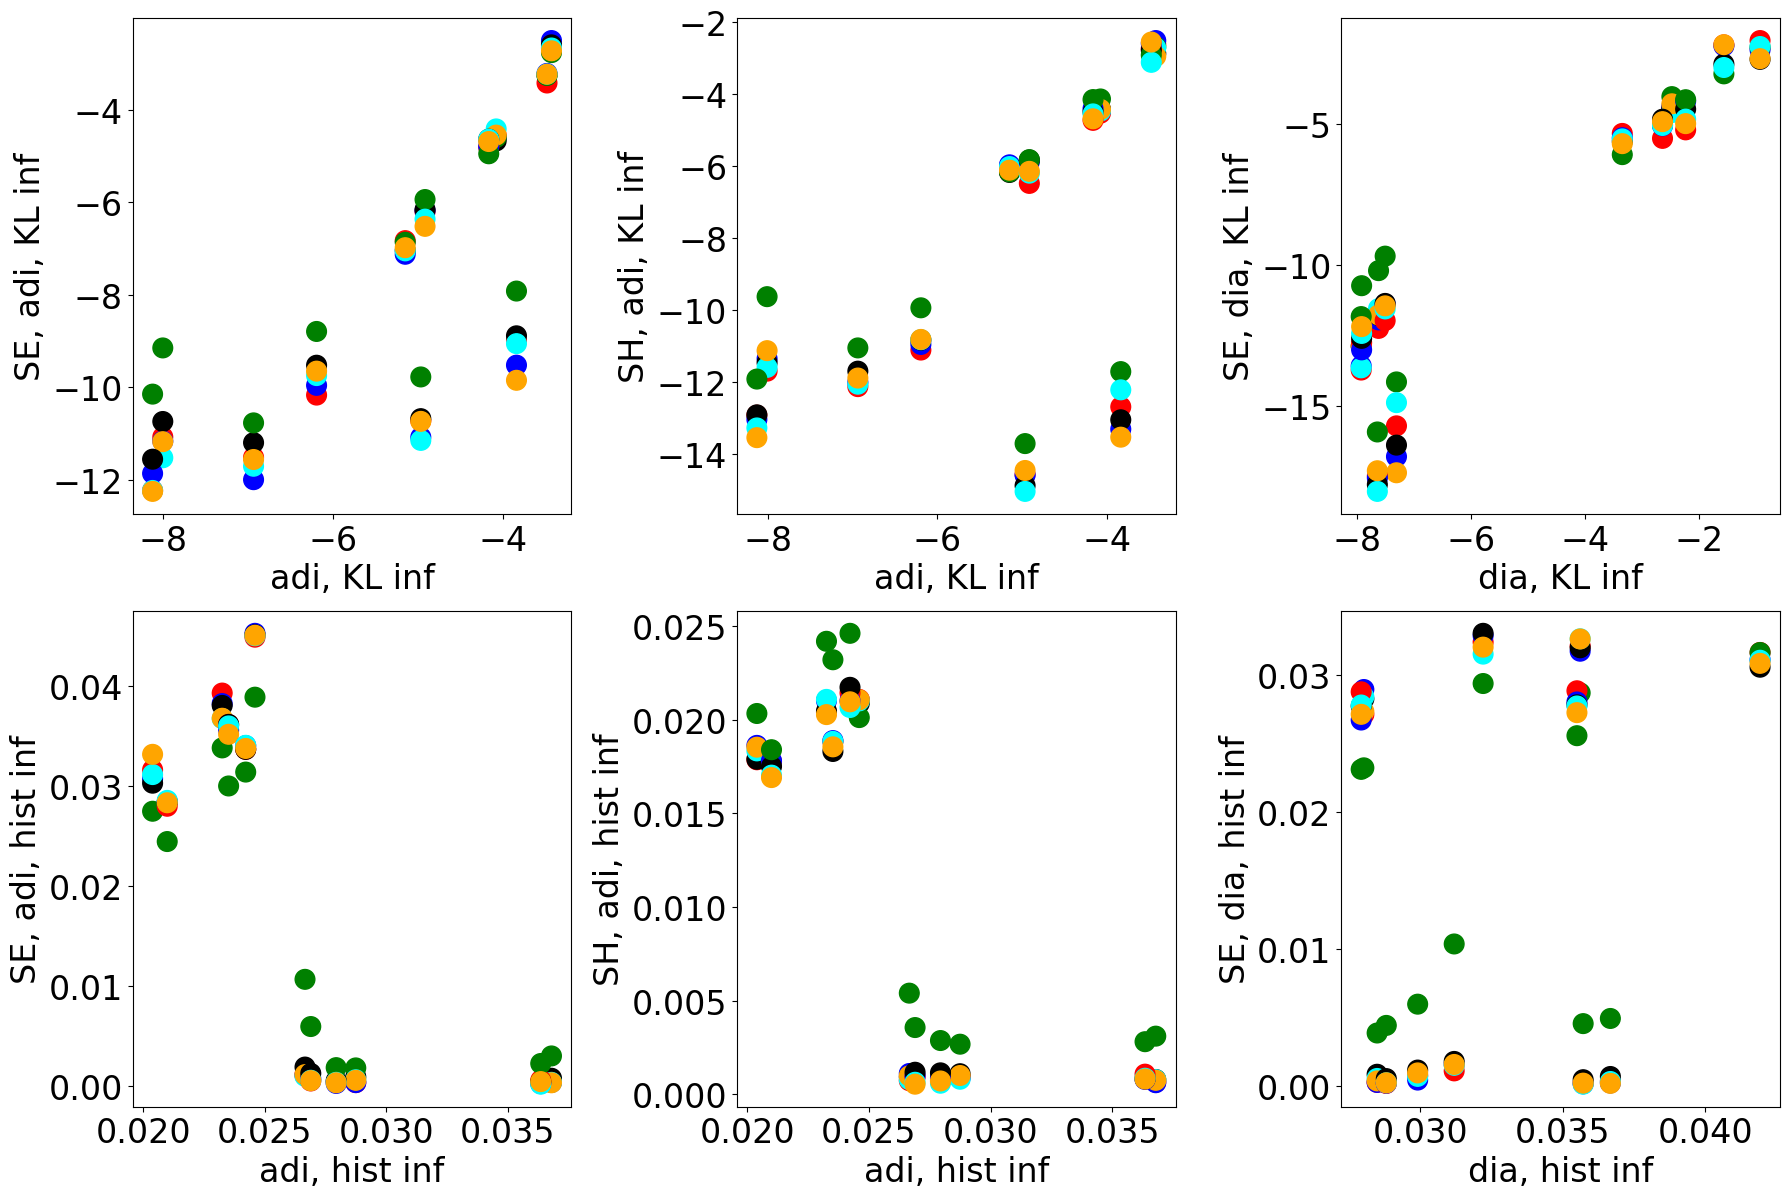

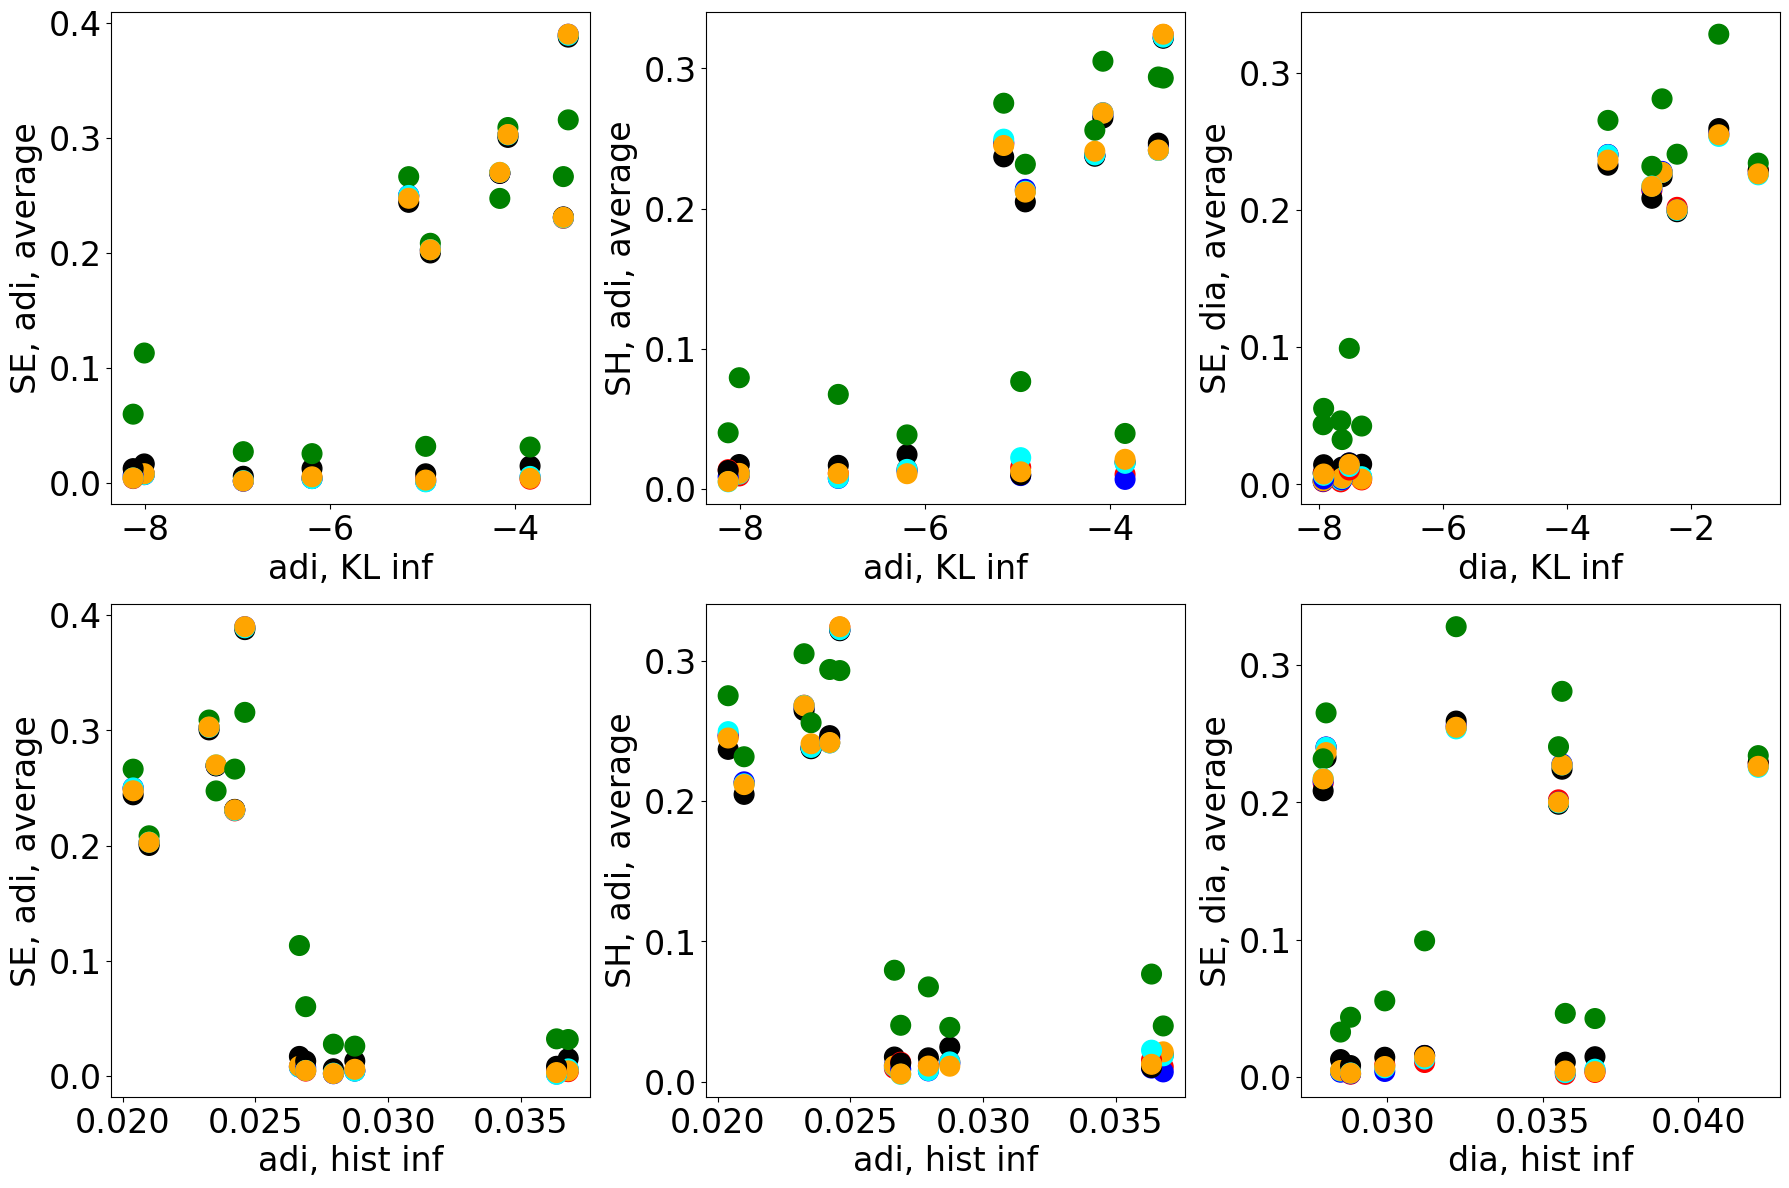

In [14]:
merged1 = merge_data(data_inf1)
plot_correlations(merged1, case=0)
plot_correlations(merged1, case=1)

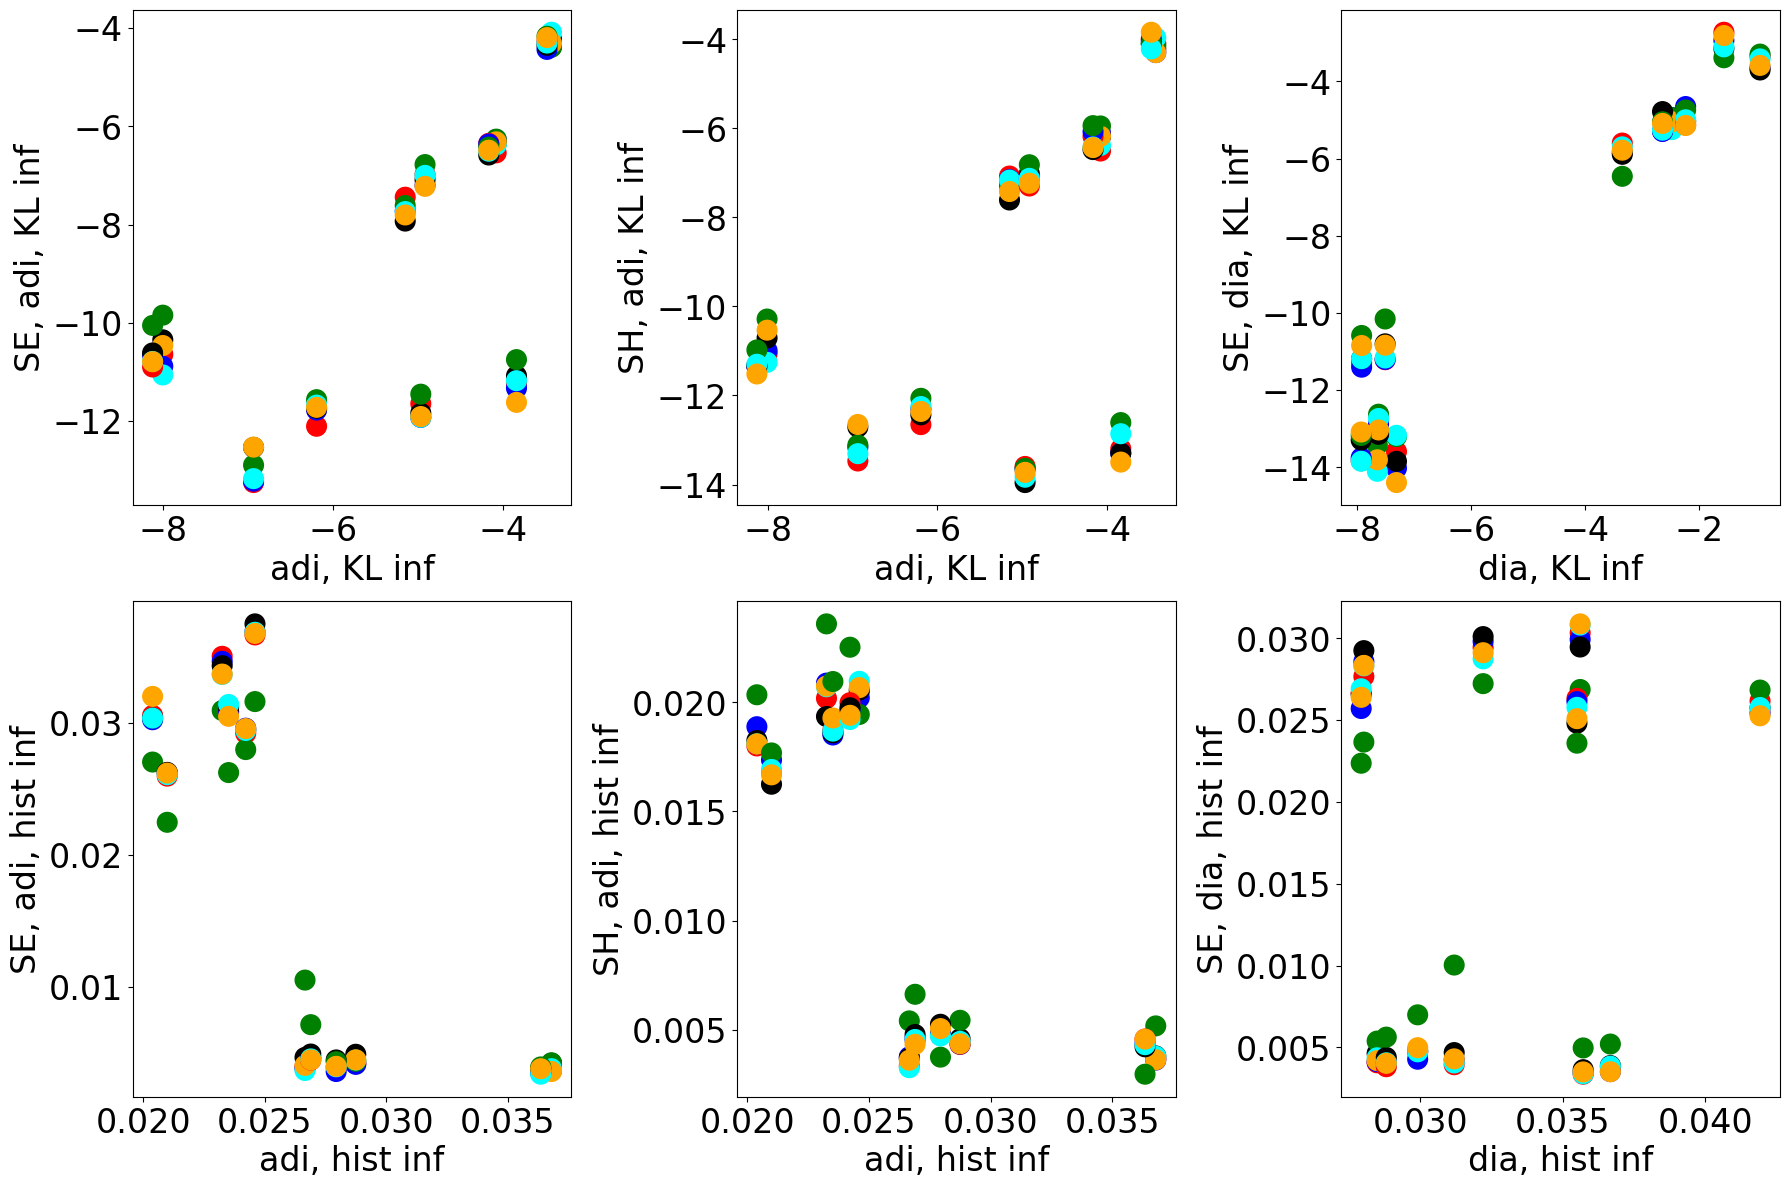

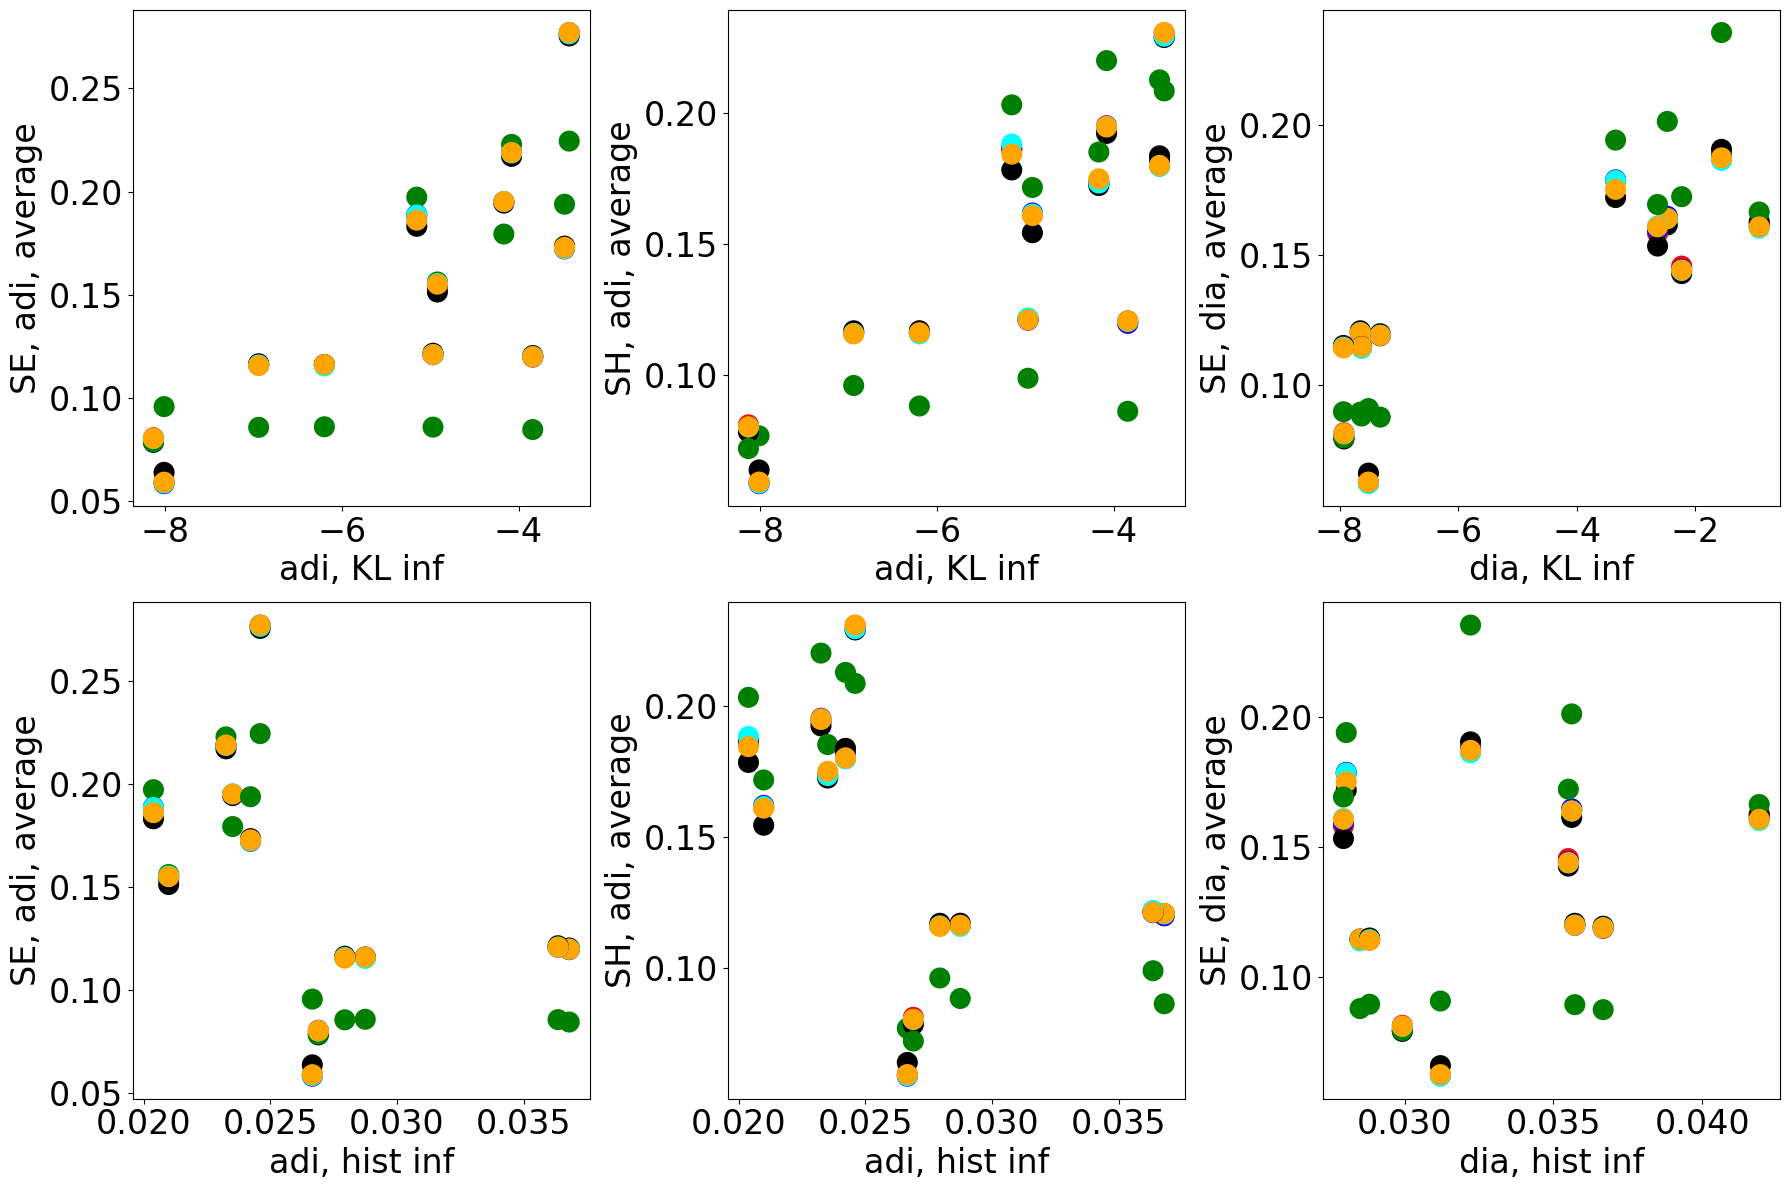

In [16]:
merged2 = merge_data(data_inf2)
plot_correlations(merged2, case=0)
plot_correlations(merged2, case=1)

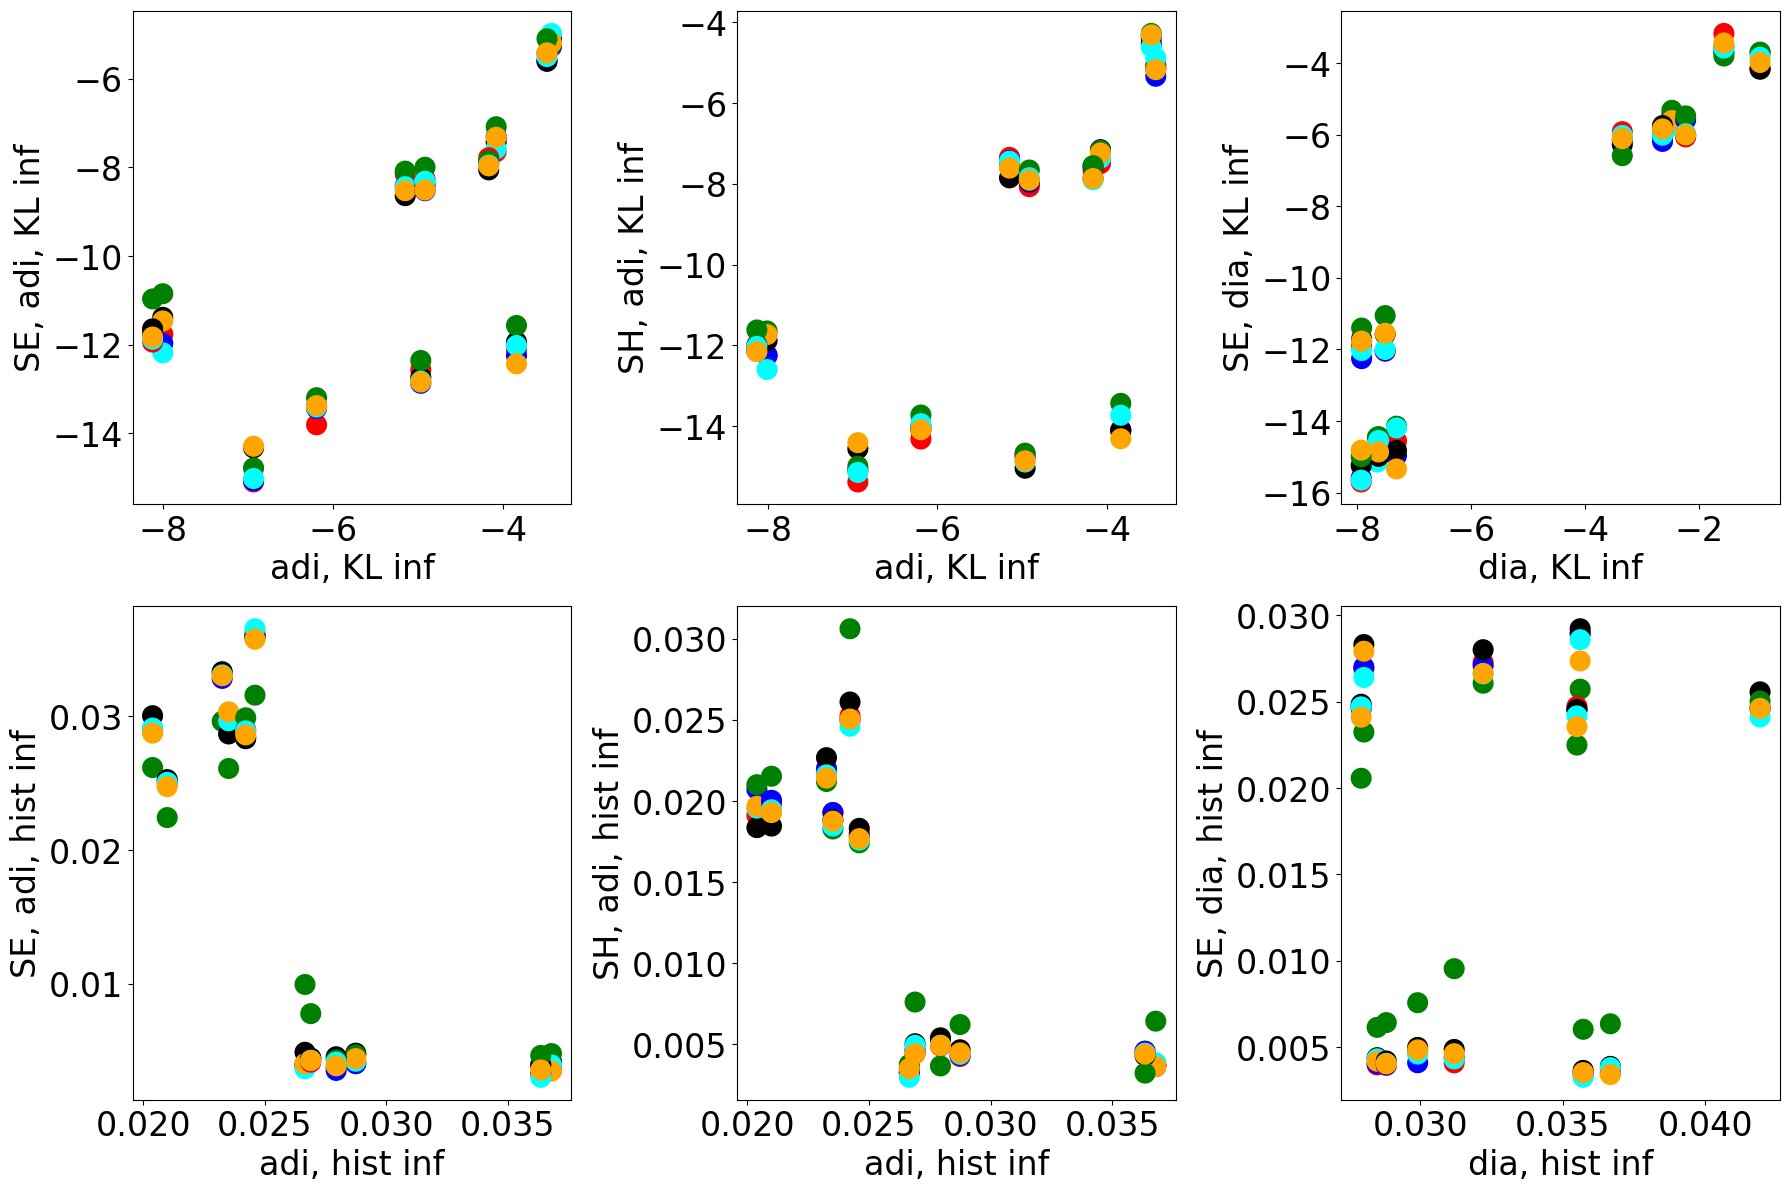

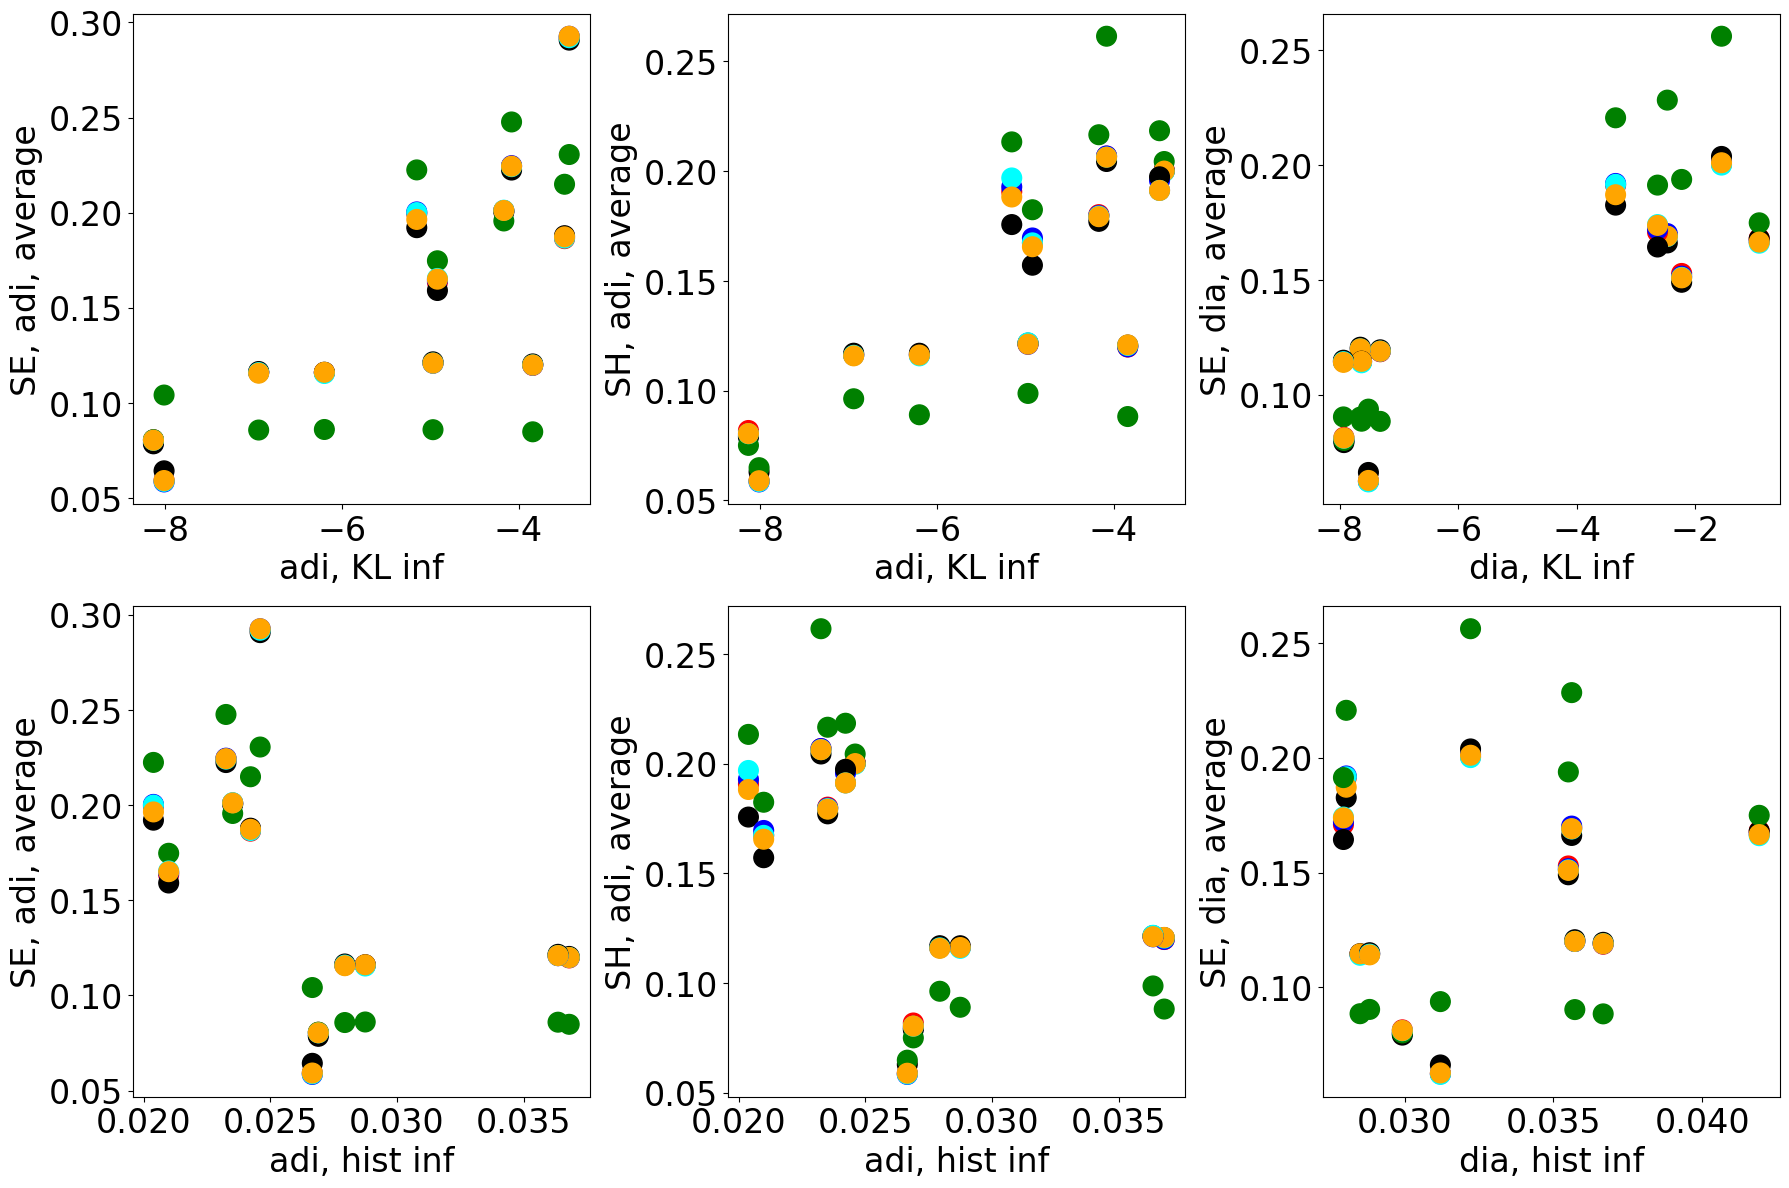

In [17]:
merged3 = merge_data(data_inf3)
plot_correlations(merged3, case=0)
plot_correlations(merged3, case=1)

# 2. Computing Elo

## 2.1. Concept Demonstration

In [14]:
def sim_elo(win_rate, nsteps = 1000):
    t, ELO_A, ELO_B, aveELO_A, aveELO_B = [], [], [], [], []

    
    RA = 1500
    RB = 1500
    aRA = 1500
    aRB = 1500
    n = 1
    
    for i in range(nsteps): # how many games 
        t.append(i)
        ELO_A.append(RA)
        ELO_B.append(RB)
        aveELO_A.append(aRA)
        aveELO_B.append(aRB)
        
    
        ksi = random.uniform(0.0, 1.0)
        SA, SB = 0.0, 0.0
        if ksi<(win_rate/100.0):
            SA, SB = 1.0, 0.0
        else:
            SA, SB = 0.0, 1.0

        EA = 1.0/(1.0 + math.pow(10, (RB-RA)/400.0) )
        EB = 1.0/(1.0 + math.pow(10, (RA-RB)/400.0) )

        # Updates:
        K = 10.0
        RA_new = RA + K*(SA - EA)
        RB_new = RB + K*(SB - EB)
        RA = RA_new
        RB = RB_new
        
        aRA = (n*aRA + RA)/(n+1)
        aRB = (n*aRB + RB)/(n+1)
        n = n + 1
        
    return t, ELO_A, ELO_B, aveELO_A, aveELO_B


In [19]:
t, Ea1, Eb1, aEa1, aEb1 = sim_elo(50.0, nsteps = 5000)
t, Ea2, Eb2, aEa2, aEb2 = sim_elo(90.9, nsteps = 5000)

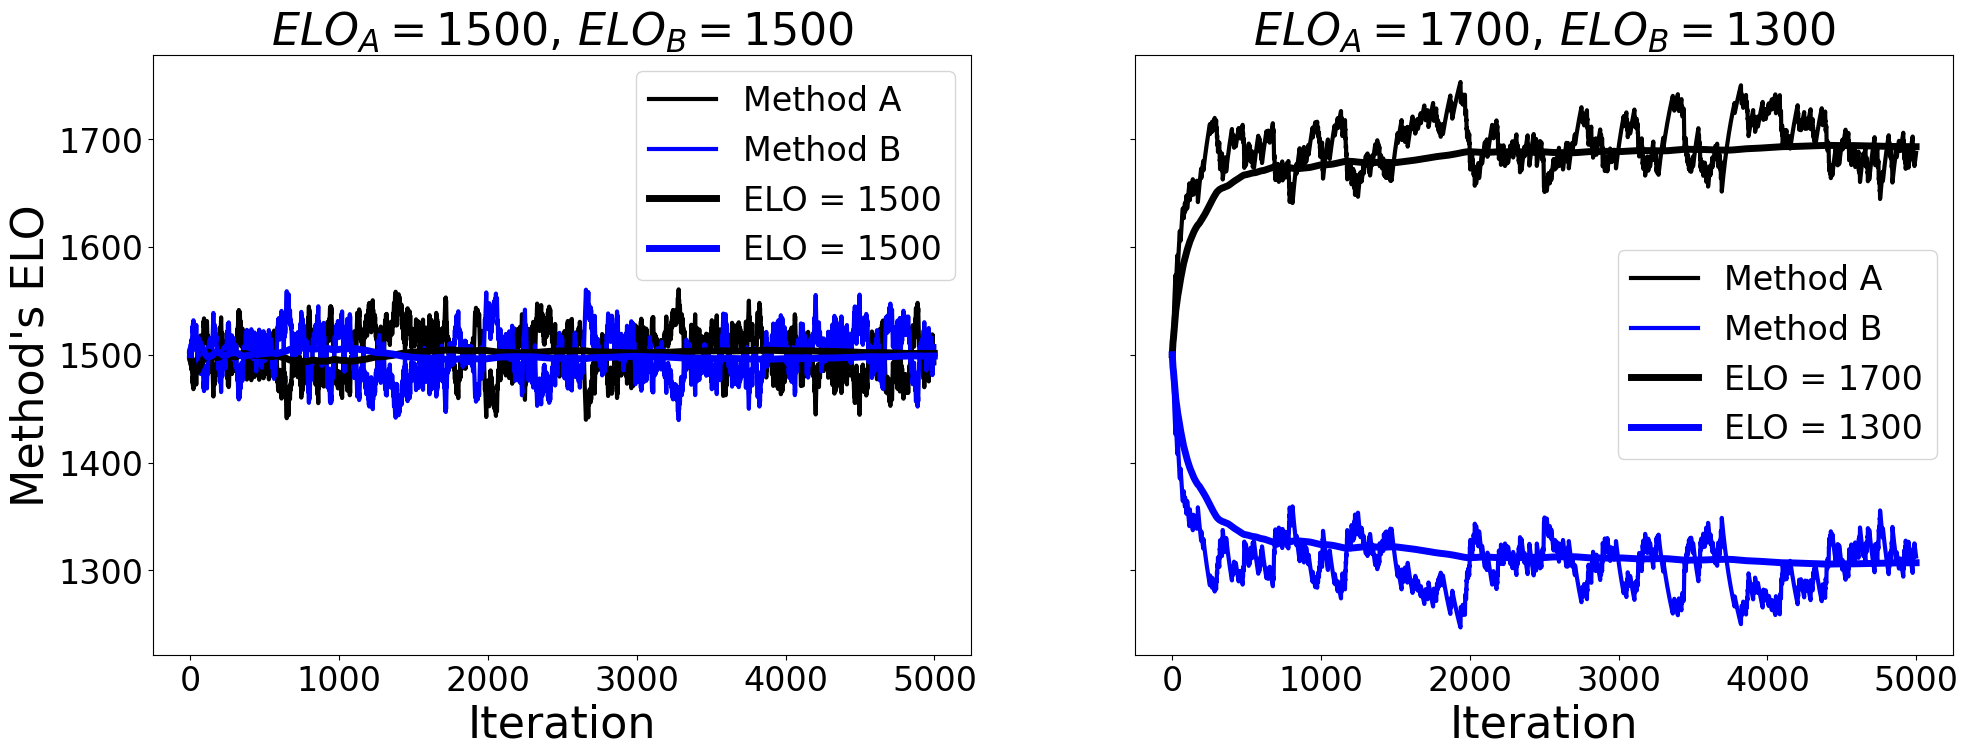

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(24, 8), sharex=True, sharey=True )

ax[0].set_title(F"$ELO_A = 1500$, $ELO_B = 1500$", fontsize=32)
ax[0].plot(t, Ea1, label="Method A", color="black", lw = 3)
ax[0].plot(t, Eb1, label="Method B", color="blue", lw = 3)
ax[0].plot(t, aEa1, label="ELO = 1500", color="black", lw = 5)
ax[0].plot(t, aEb1, label="ELO = 1500", color="blue", lw = 5)

ax[0].set_ylabel("Method's ELO", fontsize=32)
ax[0].tick_params(axis='x', labelsize=24)
ax[0].tick_params(axis='y', labelsize=24)

ax[1].set_title(F"$ELO_A = 1700$, $ELO_B = 1300$", fontsize=32)
ax[1].plot(t, Ea2, label="Method A", color="black", lw = 3)
ax[1].plot(t, Eb2, label="Method B", color="blue", lw = 3)
ax[1].plot(t, aEa2, label="ELO = 1700", color="black", lw = 5)
ax[1].plot(t, aEb2, label="ELO = 1300", color="blue", lw = 5)

ax[1].tick_params(axis='x', labelsize=24)
ax[1].tick_params(axis='y', labelsize=24)

ax[0].set_xlabel("Iteration", fontsize=32)
ax[1].set_xlabel("Iteration", fontsize=32)


ax[0].legend(fontsize=24)
ax[1].legend(fontsize=24)

## 2.2. Construct Win Matrices and Run Elo Simulator

In [19]:
def build_win_matrices(df, group_cols, method_col="Method", error_col="Error"):
    """
    Build (M, N, N) win matrices from a pandas DataFrame, 
    where games are determined by unique combinations of group_cols.

    Parameters:
    - df: pandas DataFrame with [group_cols + [method_col, error_col]]
    - group_cols: list of column names that together define a "game"
    - method_col: column with method identifiers (strings or categories)
    - error_col: column with error values (smaller = better)

    Returns:
    - W: numpy array of shape (M, N, N), win matrices
    - methods: list of method names (consistent order across all W)
    - game_keys: list of tuples of group_col values defining each game
    """
    # Enumerate methods consistently
    methods = sorted(df[method_col].unique())
    method_to_idx = {m: i for i, m in enumerate(methods)}
    N = len(methods)

    # Unique games
    grouped = df.groupby(group_cols)
    game_keys = list(grouped.groups.keys())
    M = len(game_keys)

    W = np.zeros((M, N, N), dtype=int)

    for m_idx, (game_key, sub) in enumerate(grouped):
        # sub = dataframe for one game (rows = methods)
        for _, row_i in sub.iterrows():
            for _, row_j in sub.iterrows():
                if row_i[method_col] == row_j[method_col]:
                    continue
                i_idx = method_to_idx[row_i[method_col]]
                j_idx = method_to_idx[row_j[method_col]]
                if row_i[error_col] < row_j[error_col]:
                    W[m_idx, i_idx, j_idx] = 1

    return W, methods, game_keys

In [20]:
def compute_elo_from_multimatrix(W, K=32, base_rating=1500, max_iter=100, seed=42):
    """
    Compute steady-state Elo ratings from multiple win/loss matrices.

    Parameters:
    - W: MxNxN numpy array, where W[m, i, j] = 1 if player i beat j in game type m
    - K: Elo update coefficient
    - base_rating: initial rating for all players
    - max_iter: number of times to iterate over all matchups
    - seed: random seed for reproducibility

    Returns:
    - ratings: N-element numpy array of final Elo ratings
    - t: list of iteration numbers
    - all_ratings: (max_iter, N) numpy array of rating trajectories
    """
    np.random.seed(seed)
    M, N, _ = W.shape
    ratings = np.full(N, base_rating, dtype=float)

    # collect all matchups across all game types
    match_indices = []
    for m in range(M):
        pairs = np.argwhere(W[m] + W[m].T > 0)  # pairs that played in game type m
        for i, j in pairs:
            match_indices.append((m, i, j))
    match_indices = np.array(match_indices, dtype=int)

    all_ratings, t = [], []
    for iteration in range(max_iter):
        t.append(iteration)
        all_ratings.append(np.array(ratings))

        np.random.shuffle(match_indices)
        for m, i, j in match_indices:
            if W[m, i, j] == 0 and W[m, j, i] == 0:
                continue  # no match played in this game type

            Ri, Rj = ratings[i], ratings[j]
            Ei = 1 / (1 + 10 ** ((Rj - Ri) / 400))  # expected score for i
            result = 1 if W[m, i, j] == 1 else 0   # actual outcome

            ratings[i] += K * (result - Ei)
            ratings[j] -= K * (result - Ei)

    all_ratings = np.array(all_ratings)
    return ratings, t, all_ratings

In [27]:
def run_simulation(df_merged):
    # Compute the win matrices
    
    W00, methods, game_keys = build_win_matrices(df_merged, group_cols=["model","q0", "p0", "istate"], method_col="method", 
                               error_col="SE, adi, KL inf")
    W01, _, _ = build_win_matrices(df_merged, group_cols=["model","q0", "p0", "istate"], method_col="method", 
                               error_col="SH, adi, KL inf")
    W02, _, _ = build_win_matrices(df_merged, group_cols=["model","q0", "p0", "istate"], method_col="method", 
                               error_col="SE, dia, KL inf")

    W10, methods, game_keys = build_win_matrices(df_merged, group_cols=["model","q0", "p0", "istate"], method_col="method", 
                               error_col="SE, adi, hist inf")
    W11, _, _ = build_win_matrices(df_merged, group_cols=["model","q0", "p0", "istate"], method_col="method", 
                               error_col="SH, adi, hist inf")
    W12, _, _ = build_win_matrices(df_merged, group_cols=["model","q0", "p0", "istate"], method_col="method", 
                               error_col="SE, dia, hist inf")

    W20, methods, game_keys = build_win_matrices(df_merged, group_cols=["model","q0", "p0", "istate"], method_col="method", 
                               error_col="SE, adi, average")
    W21, _, _ = build_win_matrices(df_merged, group_cols=["model","q0", "p0", "istate"], method_col="method", 
                               error_col="SH, adi, average")
    W22, _, _ = build_win_matrices(df_merged, group_cols=["model","q0", "p0", "istate"], method_col="method", 
                               error_col="SE, dia, average")
    
    print("Methods:", methods)
    print("Game keys:", game_keys)
    print("Win matrices shape:", W00.shape)
    print("W[0] (Dataset D1, Seed 0):\n", W00[0])
    
    
    # Run simulators
    r = np.zeros( (3,3, 100, 6) )

    _, t, r[0,0]  = compute_elo_from_multimatrix(W00, K=32, base_rating=1500, max_iter=100, seed=42)
    _, _, r[0,1]  = compute_elo_from_multimatrix(W01, K=32, base_rating=1500, max_iter=100, seed=42)
    _, _, r[0,2]  = compute_elo_from_multimatrix(W02, K=32, base_rating=1500, max_iter=100, seed=42)

    _, t, r[1,0]  = compute_elo_from_multimatrix(W10, K=32, base_rating=1500, max_iter=100, seed=42)
    _, _, r[1,1]  = compute_elo_from_multimatrix(W11, K=32, base_rating=1500, max_iter=100, seed=42)
    _, _, r[1,2]  = compute_elo_from_multimatrix(W12, K=32, base_rating=1500, max_iter=100, seed=42)

    _, t, r[2,0]  = compute_elo_from_multimatrix(W20, K=32, base_rating=1500, max_iter=100, seed=42)
    _, _, r[2,1]  = compute_elo_from_multimatrix(W21, K=32, base_rating=1500, max_iter=100, seed=42)
    _, _, r[2,2]  = compute_elo_from_multimatrix(W22, K=32, base_rating=1500, max_iter=100, seed=42)
    
    return t, r

In [44]:
def plot_elo_simulator(t, r):
    cat_map = {"FSSH_g_minus": "red", "FSSH_g_plus": "blue", "FSSH_g_jt": "black", 
               "IDA_FSSH_g_minus":"green", "FSSH_h_minus": "cyan", "FSSH_v_minus": "orange"}
    nmethods = len(cat_map)
    T1 = ["KL", "hist", "average"]
    T2 = ["SE, adi", "SH, adi", "SE, dia"]

    fig, ax = plt.subplots(3, 3, figsize=(24, 24), sharex=True, sharey=True )
    for a in [0, 1, 2]:
        for b in [0,1,2]:
            ax[a][b].set_title(F"{T1[a]}, {T2[b]}", fontsize=32)
            for i in range(nmethods):
                # "Raw" data
                #ax[a][b].plot(t, r[a, b, :, i], label=methods[i], color=cat_map[ methods[i] ])
            
                # Progressive average
                data = r[a, b, :, i]
                progressive_avg = np.cumsum(data) / np.arange(1, len(data)+1)
                ax[a][b].plot(t, progressive_avg, label=methods[i], color=cat_map[ methods[i] ], lw = 5)
            
            ax[a][b].tick_params(axis='x', labelsize=24)
        
        ax[a][0].set_ylabel("Method's ELO", fontsize=32)
        ax[a][0].tick_params(axis='y', labelsize=24)
        
    ax[2][0].set_xlabel("Iteration", fontsize=32)
    ax[2][1].set_xlabel("Iteration", fontsize=32)
    ax[2][2].set_xlabel("Iteration", fontsize=32)
    ax[0][0].legend(fontsize=24)

In [30]:
t, r = run_simulation(merged1)

Methods: ['FSSH_g_jt', 'FSSH_g_minus', 'FSSH_g_plus', 'FSSH_h_minus', 'FSSH_v_minus', 'IDA_FSSH_g_minus']
Game keys: [('Tully1', -10.0, 20.0, 0), ('Tully1', -10.0, 20.0, 1), ('Tully1', -6.0, 10.0, 0), ('Tully1', -6.0, 10.0, 1), ('Tully1', -6.0, 20.0, 0), ('Tully1', -6.0, 20.0, 1), ('Tully2', -10.0, 20.0, 0), ('Tully2', -10.0, 20.0, 1), ('Tully2', -6.0, 10.0, 0), ('Tully2', -6.0, 10.0, 1), ('Tully2', -6.0, 20.0, 0), ('Tully2', -6.0, 20.0, 1)]
Win matrices shape: (12, 6, 6)
W[0] (Dataset D1, Seed 0):
 [[0 0 0 1 1 1]
 [1 0 1 1 1 1]
 [1 0 0 1 1 1]
 [0 0 0 0 0 1]
 [0 0 0 1 0 1]
 [0 0 0 0 0 0]]


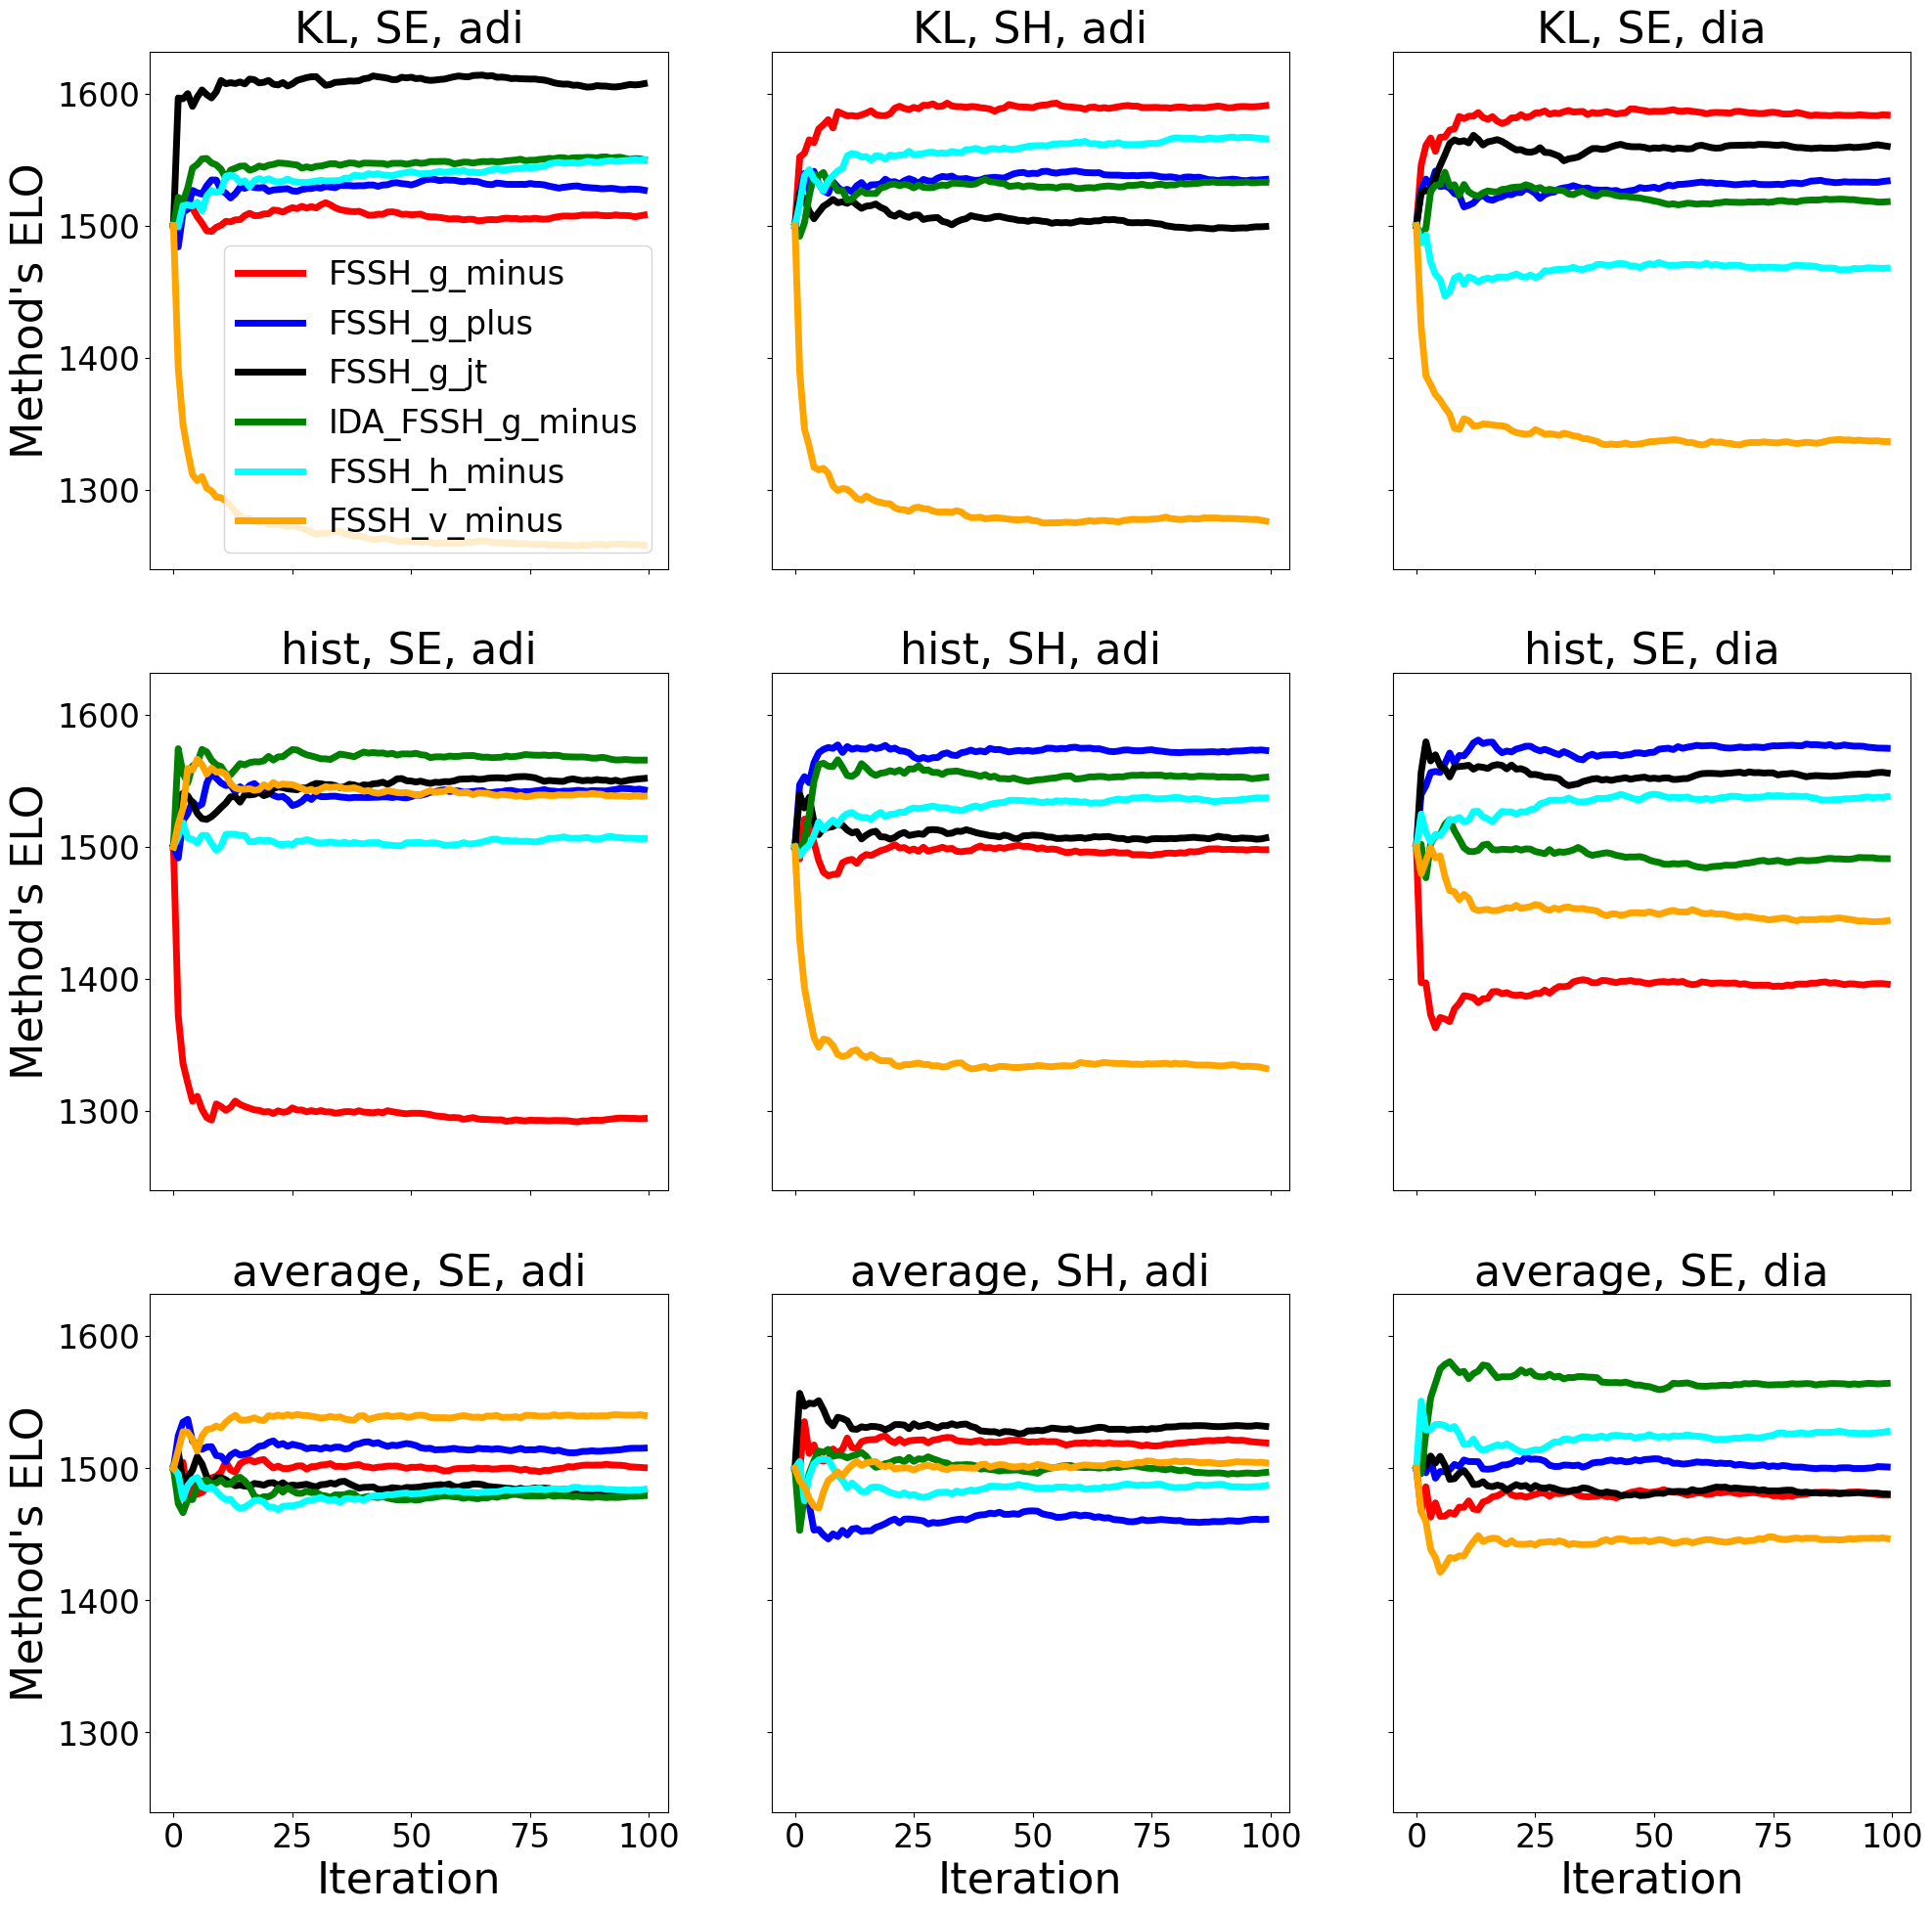

In [45]:
plot_elo_simulator(t, r)

In [36]:
t2, r2 = run_simulation(merged2)

Methods: ['FSSH_g_jt', 'FSSH_g_minus', 'FSSH_g_plus', 'FSSH_h_minus', 'FSSH_v_minus', 'IDA_FSSH_g_minus']
Game keys: [('Tully1', -10.0, 20.0, 0), ('Tully1', -10.0, 20.0, 1), ('Tully1', -6.0, 10.0, 0), ('Tully1', -6.0, 10.0, 1), ('Tully1', -6.0, 20.0, 0), ('Tully1', -6.0, 20.0, 1), ('Tully2', -10.0, 20.0, 0), ('Tully2', -10.0, 20.0, 1), ('Tully2', -6.0, 10.0, 0), ('Tully2', -6.0, 10.0, 1), ('Tully2', -6.0, 20.0, 0), ('Tully2', -6.0, 20.0, 1)]
Win matrices shape: (12, 6, 6)
W[0] (Dataset D1, Seed 0):
 [[0 0 0 1 1 1]
 [1 0 1 1 1 1]
 [1 0 0 1 1 1]
 [0 0 0 0 0 1]
 [0 0 0 1 0 1]
 [0 0 0 0 0 0]]


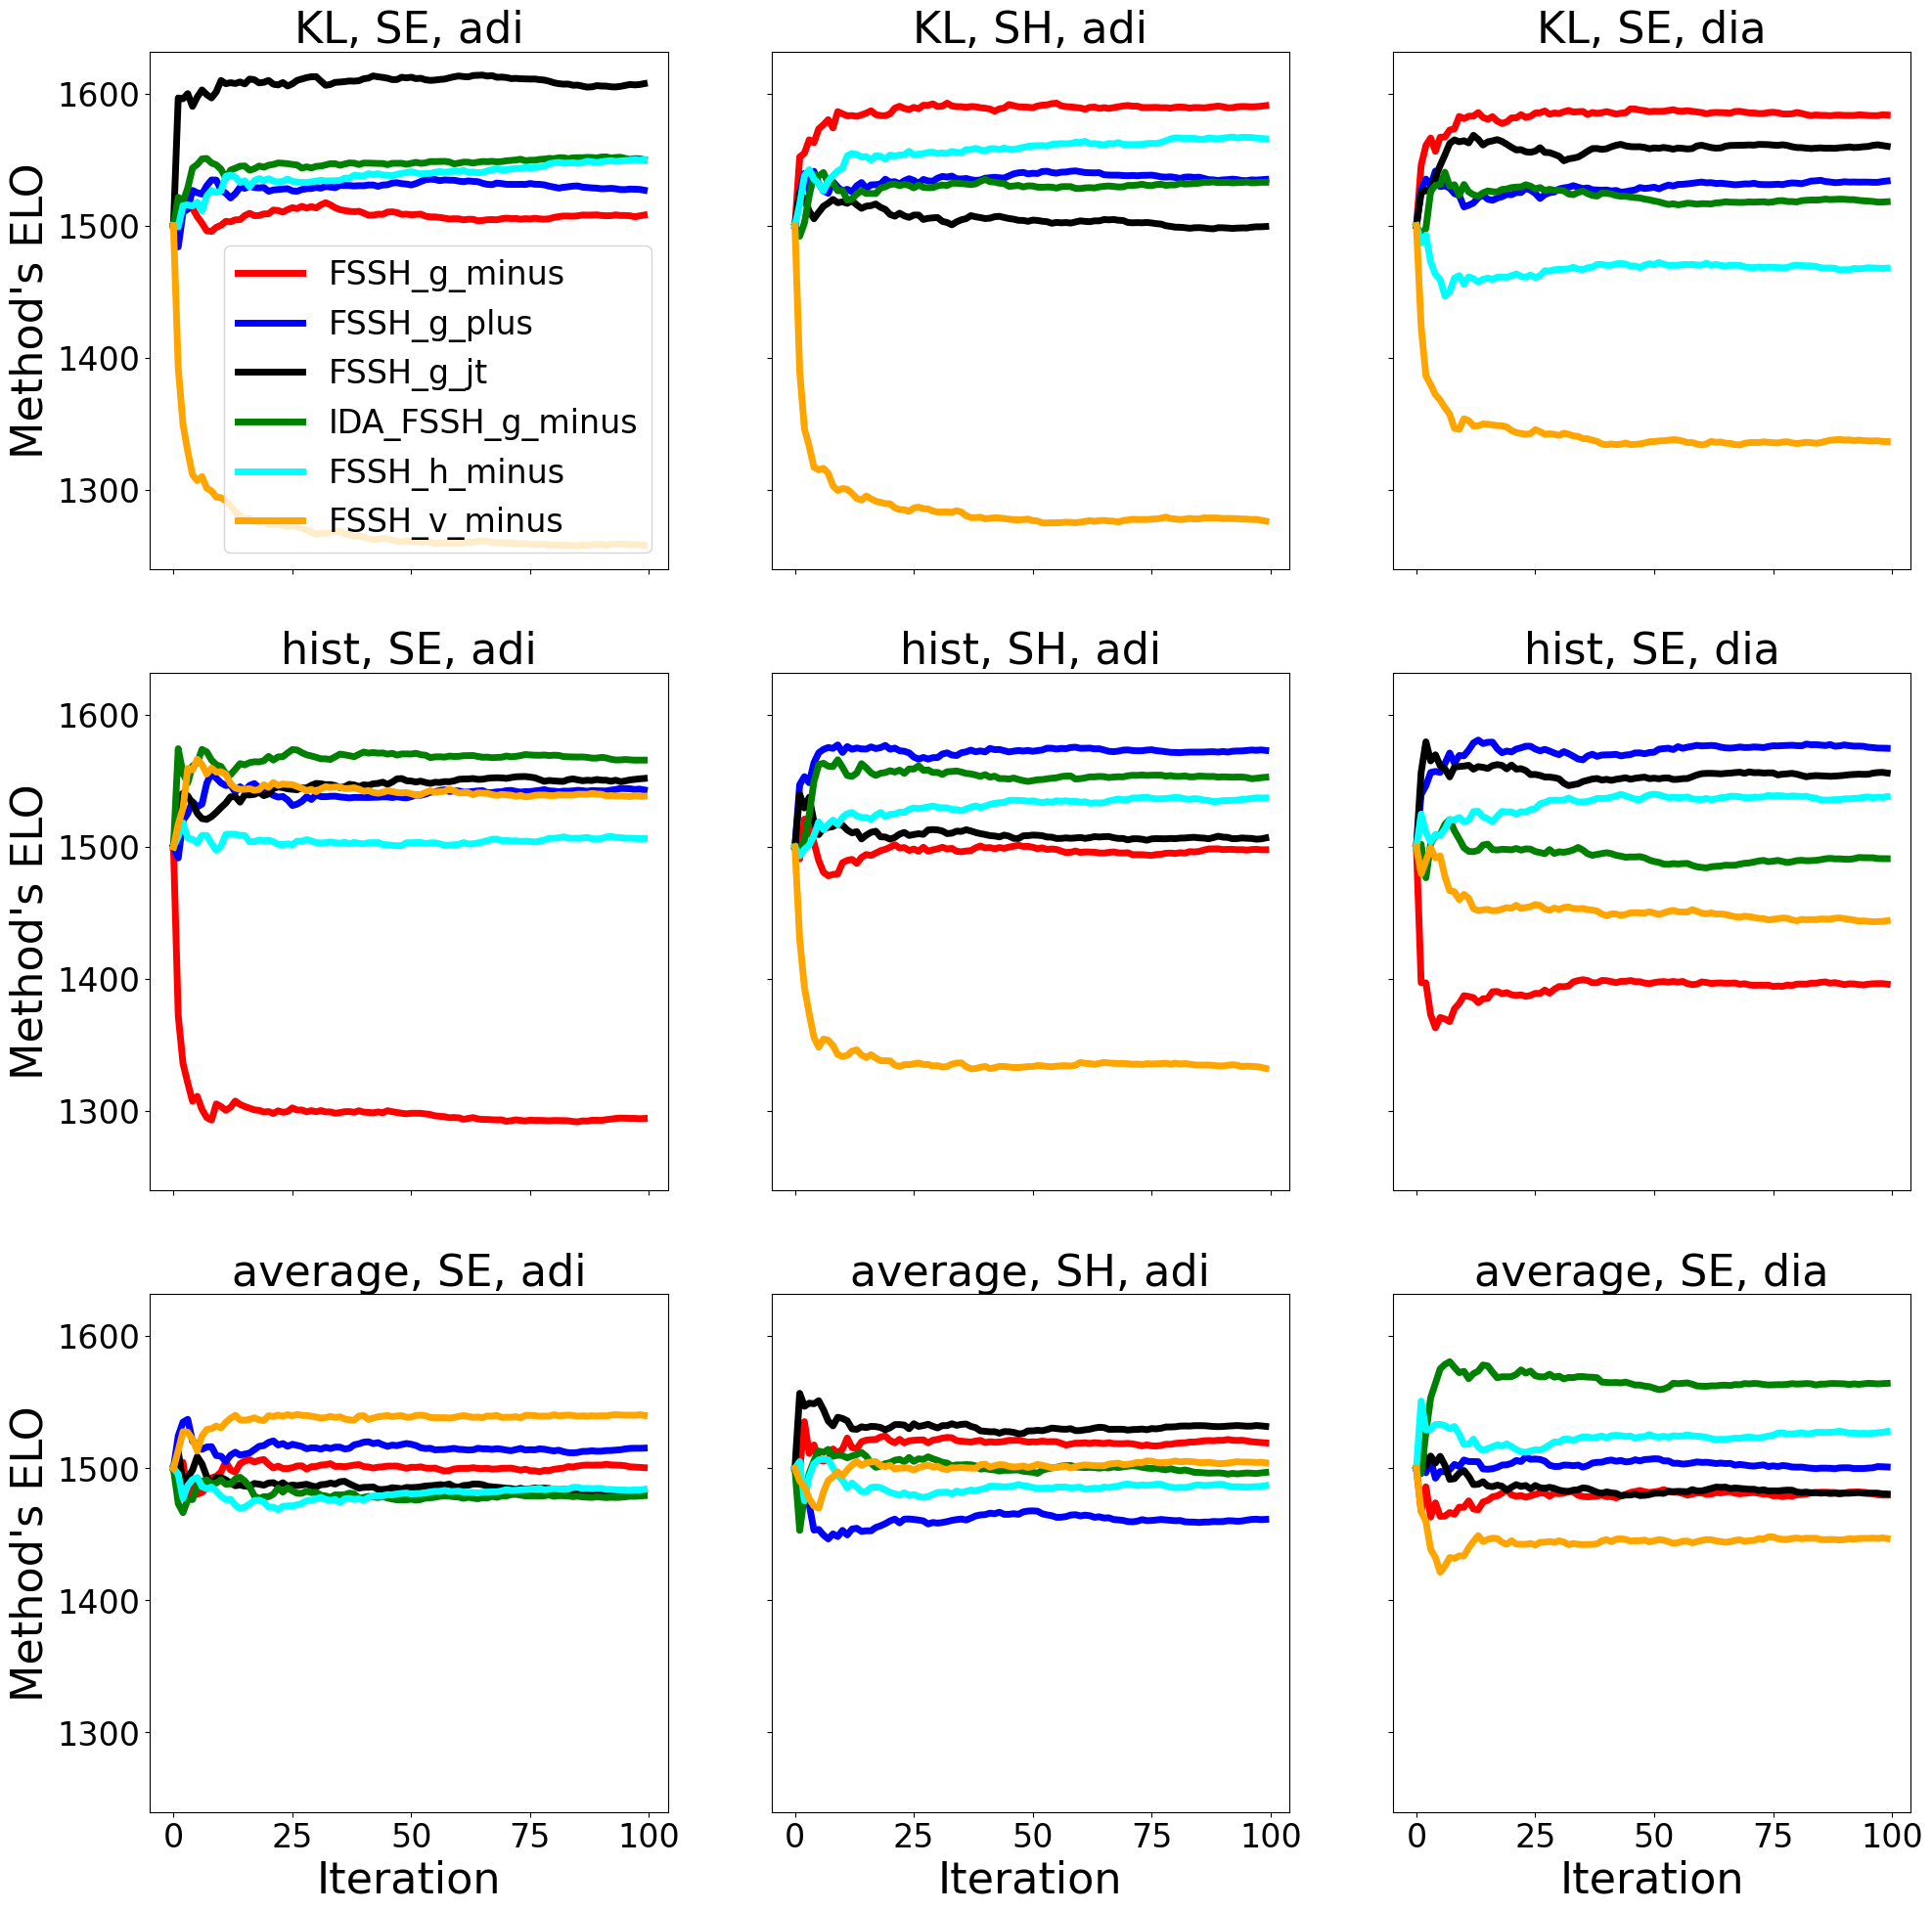

In [46]:
plot_elo_simulator(t2, r2)

In [38]:
t3, r3 = run_simulation(merged3)

Methods: ['FSSH_g_jt', 'FSSH_g_minus', 'FSSH_g_plus', 'FSSH_h_minus', 'FSSH_v_minus', 'IDA_FSSH_g_minus']
Game keys: [('Tully1', -10.0, 20.0, 0), ('Tully1', -10.0, 20.0, 1), ('Tully1', -6.0, 10.0, 0), ('Tully1', -6.0, 10.0, 1), ('Tully1', -6.0, 20.0, 0), ('Tully1', -6.0, 20.0, 1), ('Tully2', -10.0, 20.0, 0), ('Tully2', -10.0, 20.0, 1), ('Tully2', -6.0, 10.0, 0), ('Tully2', -6.0, 10.0, 1), ('Tully2', -6.0, 20.0, 0), ('Tully2', -6.0, 20.0, 1)]
Win matrices shape: (12, 6, 6)
W[0] (Dataset D1, Seed 0):
 [[0 0 0 0 1 1]
 [1 0 1 1 1 1]
 [1 0 0 1 1 1]
 [1 0 0 0 1 1]
 [0 0 0 0 0 1]
 [0 0 0 0 0 0]]


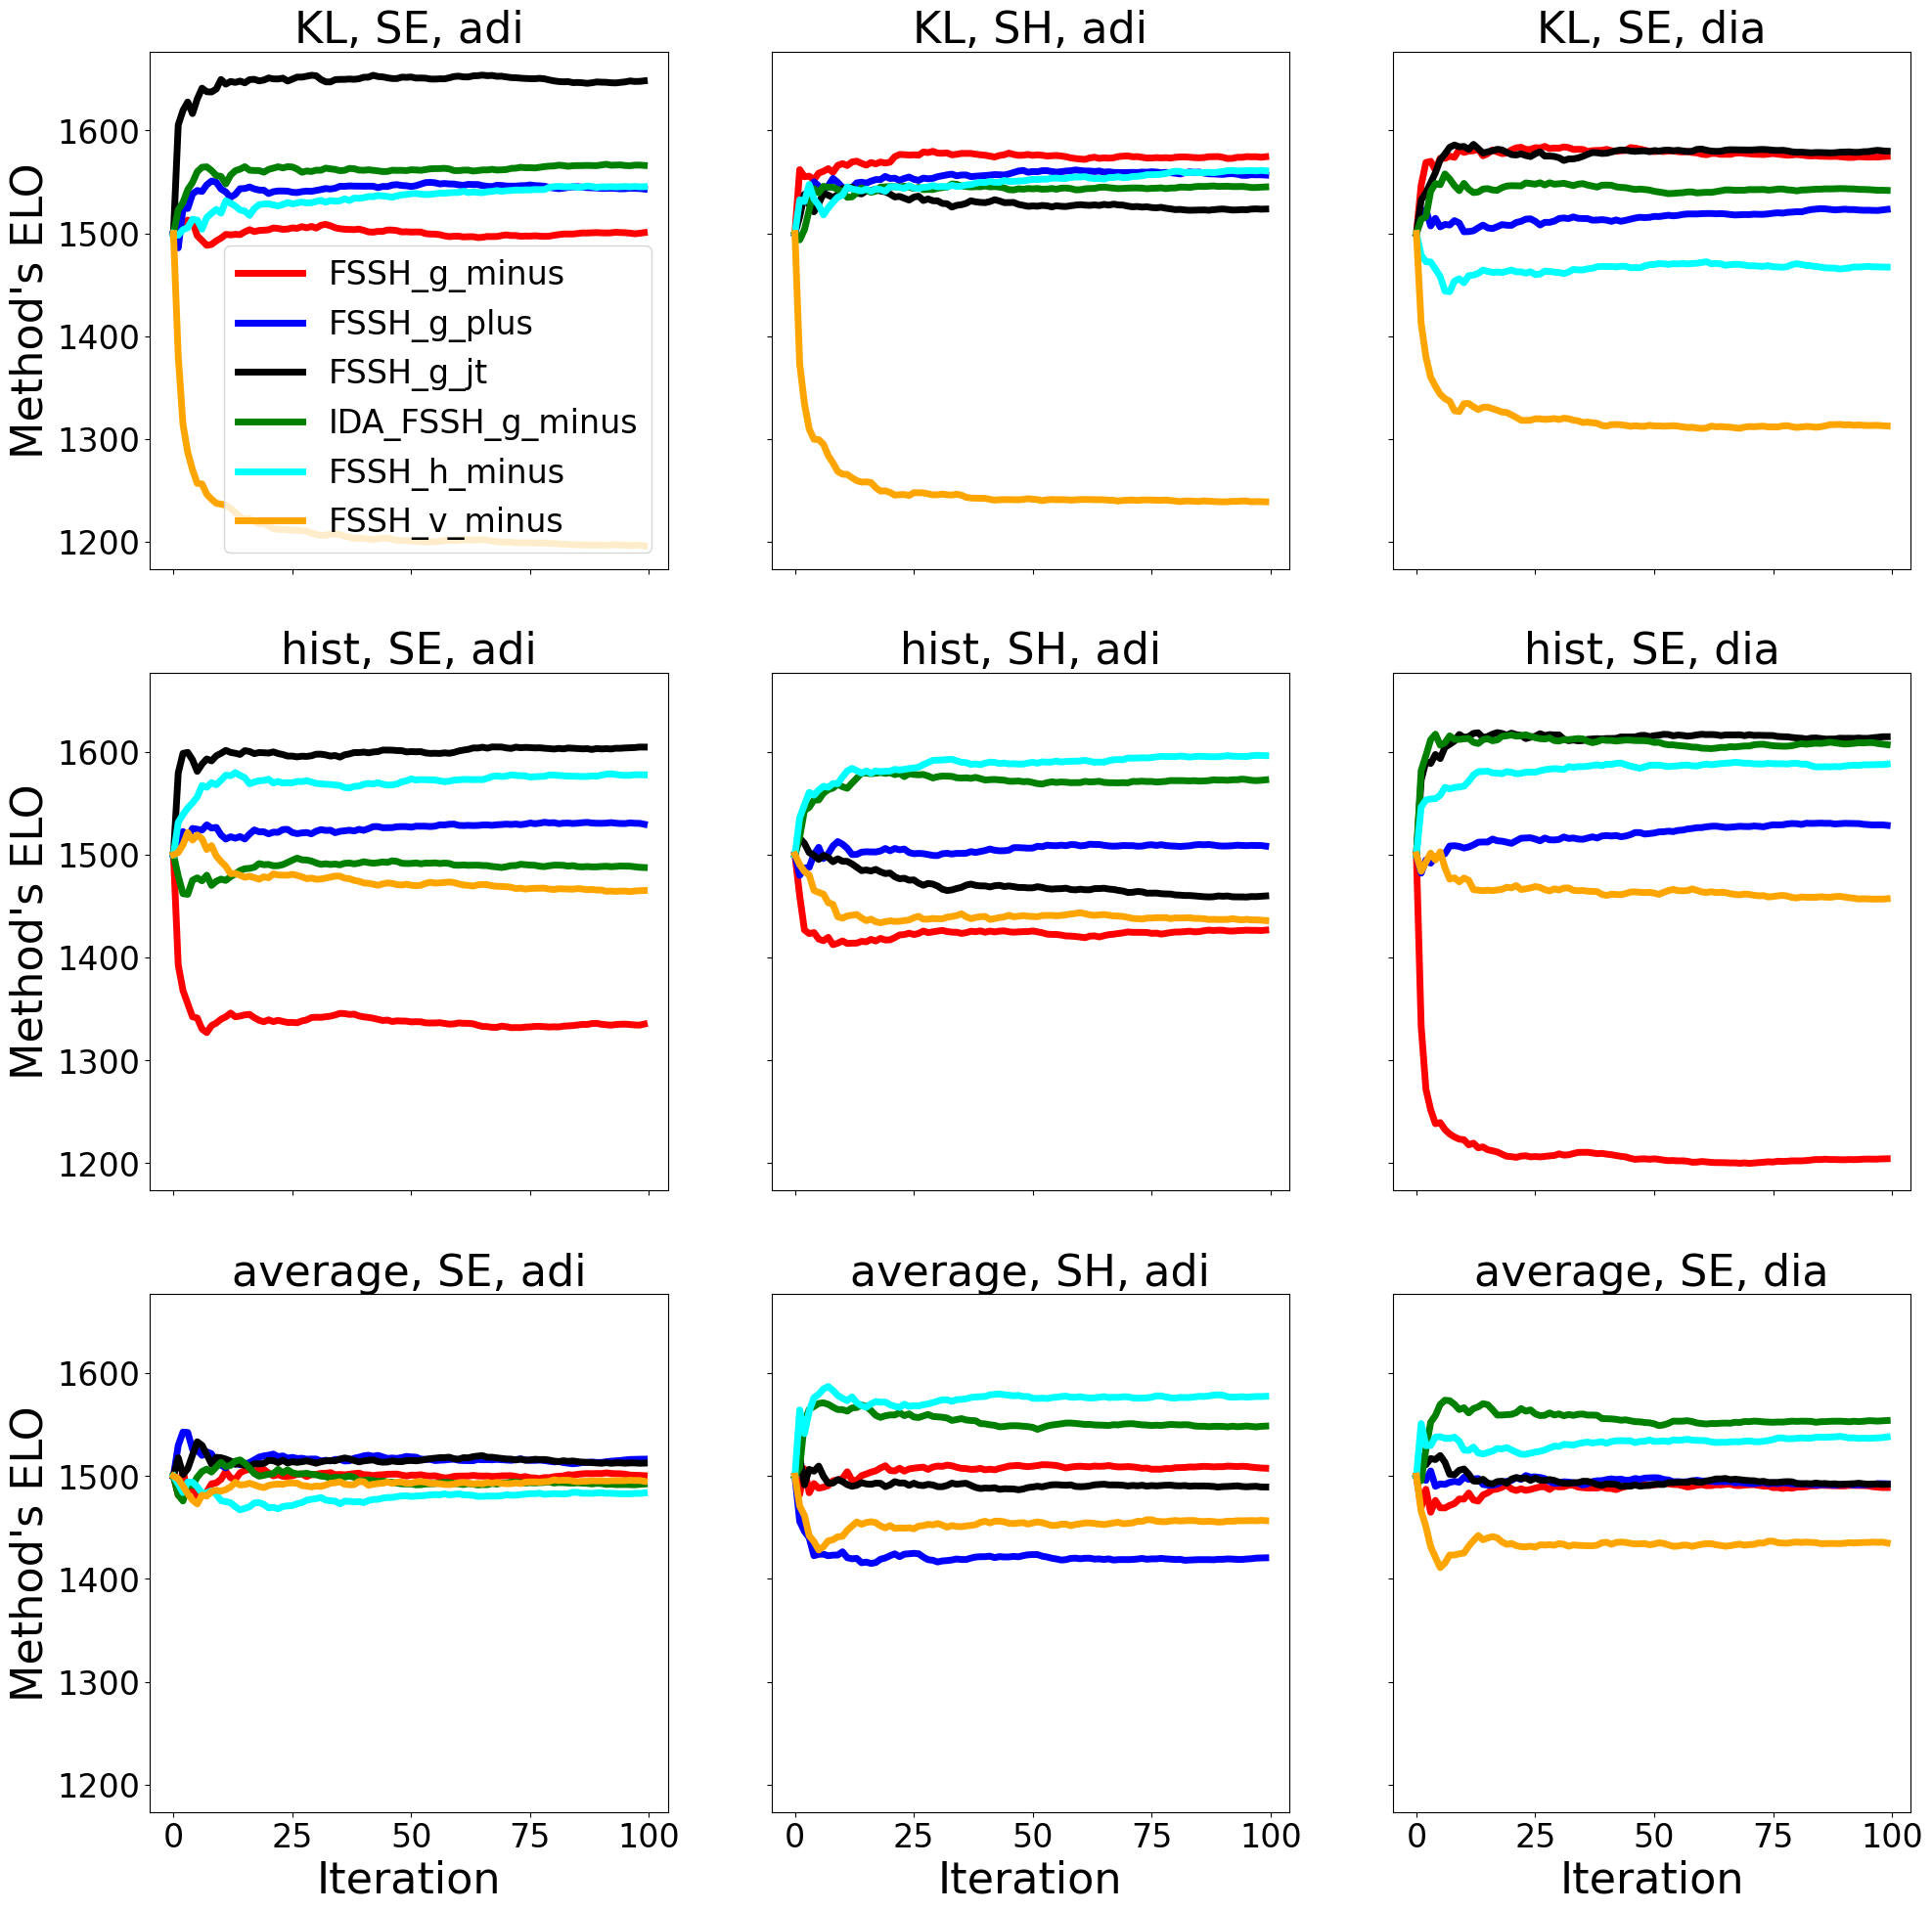

In [47]:
plot_elo_simulator(t3, r3)